# Fireveg DB - overview of taxonomic coverage

Author: [José R. Ferrer-Paris](https://github.com/jrfep) and [Ada Sánchez-Mercado](https://github.com/adasanchez)

Date: January 2025

This Jupyter Notebook includes **R code to analyse and visualise** data exported from the Fireveg Database. 

Here we will read input from a public data record of the database to answer some questions about the data coverage of the database.

```mermaid
flowchart LR
    Litrev & Form  --> Fireveg --> DR --> Code --> Q1 & Q2 & Q3
    Q2 --> Q4 & Q5 & Q6
    Fireveg[(Fireveg\nDatabase)]
    Litrev[Field work\ndata stream] 
    Form[Existing sources\n data stream] 
    BioNet(BioNet Atlas\nSpecies list) 
    BioNet -.-> Fireveg
    DR[Exported\nData Record\nVersion 1.1]
    Code{R code\nfor analysis}:::ThisRepo
    Q1[Q1. Trait descriptions]:::ThisRepo
    Q2["Q2. Taxonomic coverage\n(NSW plant species)"]:::ThisRepo
    Q3["Q3. ..."]    
    Q4["Q2.1 ..."]:::ThisRepo   
    Q5["Q2.2 ..."]:::ThisRepo
    Q6["Q2.3 etc."]:::ThisRepo
classDef ThisRepo fill:none,stroke:black,color:black;

```

## Set-up

### Load packages

In [1]:
library(ggplot2)
library(dplyr)
require(tidyr)
library(igraph)
library(ggraph)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘igraph’


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




For the treemap:

In [2]:
library(treemapify)

For [Markdown display from a code cell](https://stackoverflow.com/questions/35786496/using-r-in-jupyter-display-markdown-in-loop?rq=4).

In [3]:
library(IRdisplay)

### Paths for inputs and outputs

Locate the root directory of the repo

In [4]:
here::i_am("Notebooks/00-Overview-taxonomic-coverage-all-sources.ipynb")

here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



Relative path to local data files within project repository

In [5]:
data_dir <- here::here("data")
if (!dir.exists(data_dir))
    dir.create(data_dir)

### Read data from local folder

 <div class="alert alert-info">
     <img src='../img/open-data-2.png' width=25 alt="open data icon"/>
Data for this Notebook is available from the following OSF repository:

> Ferrer-Paris, J. R., Keith, D., & Sánchez-Mercado, A. (2024, August 15). Export data records from Fire Ecology Traits for Plants database. Retrieved from [osf.io/h96q2](https://osf.io/h96q2/)
</div>


See notebook [00-Data-download](00-Data-download.ipynb) for instructions on how to download the data programatically with R.

The data is now available in our local data folder (called `data_dir`) and we can use `readRDS` to read this file into our R session:

In [6]:
traits_table <- readRDS(here::here(data_dir,'Summary-traits-sources.rds'))
references <- readRDS(here::here(data_dir,"References-traits-sources.rds"))
quadrat_samples <- readRDS(here::here(data_dir,"Quadrat-sample-data.rds"))
trait_info <- readRDS(here::here(data_dir,"Trait-info.rds"))

Import summary of species with traits information from existing sources and field work and with extra taxonomic information (plant orders). 

In [7]:
spp_traits_table <- readRDS(here::here(data_dir,"Summary-traits-species-orders.rds")) |>
  rowwise() |>
  mutate(`Existing sources`=sum(c_across(germ8:surv1))>0) %>% # add column for summary of literature traits
  ungroup() |>
  mutate(
    `Field samples`=nquadrat>0, ## add colum for summary of field work data
    fire_ecology_traits_from=case_when(
      `Field samples` & `Existing sources` ~ "both",
      `Field samples` ~ "field",
      `Existing sources` ~ "literature",
      TRUE ~ "none"
    )
  )

## Fireveg Database

### Trait descriptions

```mermaid
flowchart LR
     Fireveg --> DR --> Code --> Q1 & Q2 & Q3
    Q2 --> Q4 & Q5
    Fireveg[(Fireveg\nDatabase)]
   
    DR[Exported\nData Record\nVersion 1.1]
    Code{R code\nfor analysis}:::ThisRepo
    Q1[Q1. Trait descriptions]:::ThisRepo
    Q2["Q2. Taxonomic coverage\n(NSW plant species)"]
    Q3["Q3. ..."]    
    Q4["Q4. ..."]   
    Q5["Q5. ..."]
classDef ThisRepo fill:none,stroke:black,color:black;

```

The data frame `trait_info` includes descriptions of all traits, here we show the priority traits that are already uploaded in the current version of the database.

In [8]:
tbl_trait_info <- trait_info %>% 
  filter(!is.na(priority)) %>%
  rowwise() %>% 
  mutate(Code=code, Trait=name, 
         Description = description,
            `Classification` = paste( 
              life_stage,
              life_history_process, 
              sep="/")) %>%
  ungroup() %>% 
    arrange(desc(life_history_process),Code) %>% 
  select(Code, Trait, Classification, Description) %>%
  knitr::kable()
    
display_markdown(paste(as.character(tbl_trait_info), collapse="\n"))

|Code   |Trait                                                |Classification              |Description                                                                                                                                   |
|:------|:----------------------------------------------------|:---------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------|
|surv1  |Resprouting - full canopy scorch                     |Standing plant/Survival     |Ordinal categories of survival and resprouting proportions for plants subjected to 100% canopy scorch                                         |
|surv4  |Regenerative Organ                                   |Standing plant/Survival     |NA                                                                                                                                            |
|surv5  |Standing plant longevity (Max)                       |Standing plant/Survival     |Age at which 50% of individuals in a cohort (excluding outliers) have died from senescence                                                    |
|surv6  |Seedbank half-life                                   |Seed/Survival               |Age at which 50% of a seed cohort in an in situ seedbank have decayed or become inviable                                                      |
|surv7  |Seed longevity                                       |Seed/Survival               |Age at which all seeds in a cohort (excluding outliers, e.g. 95th percentile) have decayed or become inviable                                 |
|repr2  |Post-fire flowering response                         |Standing plant/Reproduction |NA                                                                                                                                            |
|repr3  |Age at first flower production (from seed)           |Standing plant/Reproduction |The time taken for first individual in a recruitment cohort to produce their first reproductive organs (e.g. flowers, sporophylls)            |
|repr3a |Time to first postfire reproduction (from resprouts) |Standing plant/Reproduction |The time taken after fire for first reproductive organs (e.g. flowers, sporophylls) to be produced in a population of resprouting individuals |
|repr4  |Maturation age                                       |Standing plant/Reproduction |The time taken for 50% of individuals in a cohort [even aged recruits] to produce their first viable seed                                     |
|rect2  |Establishment pattern                                |Seedling/Recruitment        |The temporal pattern of seedling or clonal establishment through the fire cycle                                                               |
|grow1  |Age to develop regenerative/resistance organs        |Standing plant/Growth       |The time taken to develop organs or tissues enabling at least 50% of cohort survival when fully scorched in a fire                            |
|germ1  |Seedbank Type                                        |Seed/Germination            |NA                                                                                                                                            |
|germ8  |Seed dormancy type                                   |Seed/Germination            |NA                                                                                                                                            |
|disp1  |Propagule dispersal mode                             |Seed/Dispersal              |Propagule dispersal mode                                                                                                                      |

### Taxonomic coverage

```mermaid
flowchart LR
     Fireveg --> DR --> Code --> Q1 & Q2 & Q3
    Q2 --> Q4 & Q5 & Q6
    Fireveg[(Fireveg\nDatabase)]
   
    DR[Exported\nData Record\nVersion 1.1]
    Code{R code\nfor analysis}:::ThisRepo
    Q1[Q1. ...]
    Q2["Q2. Taxonomic coverage\n(NSW plant species)"]:::ThisRepo
    Q3["Q3. ..."] 
    Q4["Q4. Species in NSW"]:::ThisRepo  
    Q5["Q5. Existing sources"]:::ThisRepo  
    Q6["Q6. Field work data"]:::ThisRepo   
classDef ThisRepo fill:none,stroke:black,color:black;

```

We will now look at how many species from the NSW BioNet Atlas are represented in the fireveg database. First let's take a look at the NSW flora, and then we will query how many species have information about fire ecology traits from existing sources or field work. We will combine this information in the final subsection.

#### Plant species in NSW according to BioNet Atlas

The data frame `spp_traits_table` is based on the BioNet Altas list of species. 

This list includes around 8170 distinct taxa (based on current taxonomic status) at the species level which are considered native and alive in NSW. It also includes  around 1250 infra-species level taxa considered to be alive in NSW.

In [9]:
spp_traits_table |>
    group_by(`species level`= taxonrank %in% "Species",establishment) |>
    summarise(records=n(), `original names` = n_distinct(spp), `current names`=n_distinct(current_species), .groups = "drop") 

species level,establishment,records,original names,current names
<lgl>,<chr>,<int>,<int>,<int>
FALSE,"Alive in NSW, Native",1813,1813,1251
FALSE,"Extinct in NSW, Native",9,9,4
FALSE,Hybrid,1,1,1
FALSE,Introduced,399,399,242
FALSE,Not Known from NSW,5,5,5
TRUE,"Alive in NSW, Native",10556,10556,8169
TRUE,"Extinct in NSW, Native",38,38,28
TRUE,Introduced,3309,3309,2804
TRUE,Not Known from NSW,27,27,26


Here we focus on the current names, that means that information collected under two or more different, older taxonomic names for a single current taxonomic name is interpreted here as being equivalent to redundant information records from a single taxon. It is important to keep this in mind to avoid double counting or inconsistencies in the following queries. 

#### Fire ecology traits from existing sources

First we check the number of taxa with at least one record from existing sources:

In [10]:
spp_traits_table |>
    filter(`Existing sources`>0) |>
    group_by(`species level`= taxonrank %in% "Species",establishment) |>
    summarise(records=n(), `original names` = n_distinct(spp), `current names`=n_distinct(current_species), .groups = "drop") 

species level,establishment,records,original names,current names
<lgl>,<chr>,<int>,<int>,<int>
FALSE,"Alive in NSW, Native",1019,1019,844
FALSE,"Extinct in NSW, Native",7,7,4
FALSE,Introduced,59,59,46
FALSE,Not Known from NSW,1,1,1
TRUE,"Alive in NSW, Native",5854,5854,5509
TRUE,"Extinct in NSW, Native",22,22,20
TRUE,Introduced,696,696,669
TRUE,Not Known from NSW,17,17,16


Focusing on taxa at the species level, we want to get an overview of records from the two main sources imported in this data stream. Here we filter the `traits_table` data frame which has information about main sources and the primary sources references by each record.

In [11]:
summary_per_source <- traits_table |> 
    filter(taxonrank %in% "Species") |>
    group_by(main_source) |>
    summarise(
        records=n_distinct(rid),
        traits = n_distinct(traitcode),
        species=n_distinct(current_species), 
        sources=n_distinct(primary_source))

In [12]:
summary_per_source

main_source,records,traits,species,sources
<chr>,<int>,<int>,<int>,<int>
NSWFFRDv2.1,9486,12,2549,203
austraits-6.0.0,39820,5,6173,153


There are a few problems with some sources. The Austraits data includes the NSWFFRD data, so we should exclude this to avoid the most obvious duplicate entries. Other duplicates might still be present, but a manual curation of the source list is needed to flag this. 

Another problem is that some items in the source list do not have reference information in the database (no entries in the `references` data frame. These sources are mentioned in the primary source column, but bibliographic details are incomplete or missing from our database:

In [13]:
traits_table |> 
    filter(!primary_source %in% references$ref_code) |>
    distinct(primary_source) |> arrange() |> pull()

[1] "JRS_2004"                    "KNP plots"                  
 [3] "Latz_2004"                   "Liddle_2004"                
 [5] "Albrecht_2004"               "Brock_2004"                 
 [7] "Brennan_2004"                "Unknown"                    
 [9] "Brock_2005"                  "Nitmiluk plots"             
[11] "Yates_2003"                  "Cowie_2019"                 
[13] "Nano_2005"                   "Cowie_2004"                 
[15] "Duguid_2004"                 "I.D.Cowie"                  
[17] "Crowley_2007; Paula_2009"    "Tooth_2013"                 
[19] "WAH_2022"                    "Murray_1986"                
[21] "ODowd_1986"                  "Davidson_1984"              
[23] "Berg_1975"                   "Herrera_1998"               
[25] "Sen_1982"                    "Tomlinson_1986"             
[27] "Enright_1995"                "Ridley_1930"                
[29] "Cook_1987"                   "Corlett_1996"               
[31] "vanRheedevanOudtshoorn_1999" "Zona_1989"                  
[33] "Zona_2001"                   "Milton_2001"                
[35] "vanderPijl_1982"             "Whelan_1986"                
[37] "Baraloto_2007"               "MorenoCasasola_1994"        
[39] "Gunn_1999"                   "Foster_1986"                
[41] "Young_1992"                  "Cremer_1977"                
[43] "Howe_1986"                   "Kozlowski_1972"             
[45] "Hocking_1987"                "Rutledge_2019"              
[47] "Agami_1988"                  "Mori_1998"                  
[49] "Bouman_2000"                 "Gibson_1995"                
[51] "Garrison_2000"               "authors"                    
[53] "Williams_2011"               "Benson McDougall 2000"      
[55] "Benson 1986"

If we exclude those there is a drop in the number of records and species.

In [14]:
traits_table |>
    filter(taxonrank %in% "Species") |>
    filter(!primary_source %in% 'Kenny Orscheg Tasker Gill Bradstock 2014', # this is the same as NSWFFRDv2.1
           primary_source %in% references$ref_code) |> # exclude transcription errors
    group_by(main_source) |>
    summarise(
        total=n(), 
        records=n_distinct(rid), 
        species=n_distinct(current_species), 
        sources=n_distinct(primary_source))

main_source,total,records,species,sources
<chr>,<int>,<int>,<int>,<int>
NSWFFRDv2.1,11010,9482,2549,202
austraits-6.0.0,34204,33613,5997,100


#### Field work data

Next, we look at the taxa represented in the field work data. How many species have at least one record in the field sample?

In [15]:
spp_traits_table |>
    filter(`Field samples`) |>
    group_by(`species level`= taxonrank %in% "Species",establishment) |>
    summarise(records=n(), `original names` = n_distinct(spp), `current names`=n_distinct(current_species), .groups = "drop") 

species level,establishment,records,original names,current names
<lgl>,<chr>,<int>,<int>,<int>
FALSE,"Alive in NSW, Native",68,68,68
FALSE,Introduced,2,2,2
TRUE,"Alive in NSW, Native",812,812,806
TRUE,Introduced,84,84,81


In order to get more detailed break down of numbers, we use the `quadrat_samples` data frame:

In [16]:
quadrat_samples |> 
    filter(!is.na(species_code),
           taxonrank %in% "Species") |>
    group_by(survey_name) |>
    summarise(
        locations = n_distinct(visit_id),
        visits  = n_distinct(visit_id, visit_date),
        samples  = n_distinct(visit_id, visit_date, sample_nr),
        records = n(), 
        species = n_distinct(species),
        current_species = n_distinct(current_species), 
        codes = n_distinct(species_code))

survey_name,locations,visits,samples,records,species,current_species,codes
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Alpine Bogs,6,6,120,1435,109,109,109
KNP AlpAsh,8,8,32,593,85,85,85
Mallee Woodlands,61,85,510,7054,129,129,129
NEWNES,20,20,383,2950,109,109,109
Rainforests NSW-Qld,10,10,60,1503,271,270,271
Robertson RF,2,2,8,207,51,51,51
SthnNSWRF,4,4,15,162,67,67,67
TO BE CLASSIFIED,3,3,11,374,128,127,128
UplandBasalt,27,27,80,1454,231,230,231


The Mallee Woodlands survey is a longer time series of observation in a single region in Western New South Wales, while all the other surveys represent samples completed after the 2019-2020 fires in Eastern New South Wales. We will calculate summary statistics for these two groups:

In [17]:
summary_per_survey <- quadrat_samples |> 
    filter(!is.na(species_code),
           taxonrank %in% "Species") |>
    group_by(survey_group=survey_name %in% "Mallee Woodlands") |>
    summarise(
        locations = n_distinct(visit_id),
        visits  = n_distinct(visit_id, visit_date),
              samples  = n_distinct(visit_id, visit_date, sample_nr),
              records = n(), 
              species = n_distinct(species),
              current_species = n_distinct(current_species), 
              codes = n_distinct(species_code)) |> 
    arrange(survey_group)

In [18]:
summary_per_survey

survey_group,locations,visits,samples,records,species,current_species,codes
<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
FALSE,85,85,714,8936,773,765,773
TRUE,61,85,510,7054,129,129,129


#### Summary from all sources

If we focus only on the taxa at the species level which are native and alive in NSW, we can look at the overlap between both field work data and existing sources:

In [19]:
spp_traits_table |> 
    filter(
           taxonrank %in% "Species",
           establishment %in% "Alive in NSW, Native") |>
    group_by(`Field samples`, `Existing sources`) |>
    summarise(total = n_distinct(scientific_name), 
              total_current = n_distinct(current_species), 
              .groups = "drop")

Field samples,Existing sources,total,total_current
<lgl>,<lgl>,<int>,<int>
FALSE,FALSE,4574,3844
FALSE,TRUE,5129,4843
TRUE,FALSE,87,87
TRUE,TRUE,724,723


And the same for all species (native and introduced):

In [20]:
spp_traits_table |> 
    filter(
           taxonrank %in% "Species") |>
    group_by(`Field samples`, `Existing sources`) |>
    summarise(total = n_distinct(scientific_name), 
              total_current = n_distinct(current_species), 
              .groups = "drop")

Field samples,Existing sources,total,total_current
<lgl>,<lgl>,<int>,<int>
FALSE,FALSE,7195,6140
FALSE,TRUE,5793,5484
TRUE,FALSE,100,100
TRUE,TRUE,795,793


As mentioned above, there might be some overlaps in these numbers due to a species being represented by multiple records with different older/outdated names. Best way to get a total number of current species included in the database is this:

In [21]:
total_records <- spp_traits_table |> 
    filter(
           taxonrank %in% "Species") |>
    filter(`Field samples` | `Existing sources`) |>
    summarise(total_current=n_distinct(current_species))

In [22]:
total_records

total_current
<int>
6287


Is this the same as the sum of the values in the above table?

In [23]:
5484+100+793

[1] 6377

Now we can prepare a summary of all data inputs:

In [24]:
new_surveys <- quadrat_samples |> filter(!survey_name %in% c("Mallee Woodlands"))
old_surveys <- quadrat_samples |> filter(survey_name %in% c("Mallee Woodlands"))
total_spp <- pull(total_records,total_current)
NSWFFRD_records <- filter(summary_per_source, main_source %in% 'NSWFFRDv2.1')
Austraits_records <- filter(summary_per_source, main_source %in% 'austraits-6.0.0')
Postfire_samples <- filter(summary_per_survey, !survey_group)
Mallee_samples <- filter(summary_per_survey, survey_group)

In [25]:
tbl = sprintf("
| Type	| Unit of observation	| Spatial information	| Number of records	| Number of taxa (including non-native)	| Data source |
|---|---|---|---|---|---|
| **Primary Observations** |
| Post-fire field surveys | Individual | %s sites | %s | %s  | East coast post-fire surveys 2020-2022 |
| Time series field observations | Individual | %s sites | %s | %s | Mallee vegetation dynamics 2007-2018 [@Keith_Tozer_2012] |
| **Compilations** |
| Fire response 	| Species	| Not applicable	| %s	| %s	 | %s sources compiled in NSW plant fire response database [@Kenny2014] | 
|Species traits	| Individuals / Populations / Species	| Variable |	%s	| %s	 | %s sources compiled in AusTraits plant database [@Falster2021] |
| Total | |  |  | %s  |
", 
              Postfire_samples$locations, Postfire_samples$records, Postfire_samples$current_species,
            Mallee_samples$locations, Mallee_samples$records, Mallee_samples$current_species,
              NSWFFRD_records$records, NSWFFRD_records$species, NSWFFRD_records$sources,
              Austraits_records$records, Austraits_records$species, Austraits_records$sources,
               total_spp
             )

display_markdown(tbl)


| Type	| Unit of observation	| Spatial information	| Number of records	| Number of taxa (including non-native)	| Data source |
|---|---|---|---|---|---|
| **Primary Observations** |
| Post-fire field surveys | Individual | 85 sites | 8936 | 765  | East coast post-fire surveys 2020-2022 |
| Time series field observations | Individual | 61 sites | 7054 | 129 | Mallee vegetation dynamics 2007-2018 [@Keith_Tozer_2012] |
| **Compilations** |
| Fire response 	| Species	| Not applicable	| 9486	| 2549	 | 203 sources compiled in NSW plant fire response database [@Kenny2014] | 
|Species traits	| Individuals / Populations / Species	| Variable |	39820	| 6173	 | 153 sources compiled in AusTraits plant database [@Falster2021] |
| Total | |  |  | 6287  |


Now, we will create a visualisation of represented plant orders based on an example from:
http://wilkox.org/treemapify/

We select from the table all taxa with rank of species, and we group by current scientific name, then we summarise data from field samples and existing sources. We then extract the genus name and categorise species according to the source of the fire ecology traits. We group small orders.


In [26]:
oos <- table(spp_traits_table$rank_order)
gt_table <- spp_traits_table |>
    filter(taxonrank %in% "Species") |>
    group_by(rank_order, current_species) |>
    summarise(
        `Field samples`=any(`Field samples`),
        `Existing sources`=any(`Existing sources`),
        .groups = "drop") |>
    mutate(
        genus = str_split_i(current_species," ",1),
        fire_ecology_traits_from=case_when(
          `Field samples` & `Existing sources` ~ "both",
          `Field samples` ~ "field",
          `Existing sources` ~ "literature",
          TRUE ~ "none"),    
        rank_order = case_when(
            rank_order %in% names(oos)[oos<10] ~ "small orders",
            is.na(rank_order) ~ "unknown",
            TRUE ~ rank_order
        )
      )
clrs <- c(none="aliceblue", field="yellow", literature="orange", both="maroon")

We check which order are missing data on fire ecology traits:

In [27]:
dim(gt_table)
# check that any(duplicated(gt_table$current_species)) is FALSE
gt_table |>
    group_by(rank_order,fire_ecology_traits_from) |>
    summarise(total=n(), .groups='drop') |>
    pivot_wider(id_cols=rank_order, 
            names_from = fire_ecology_traits_from, 
            values_from = total) |>
    filter(is.na(both),is.na(field),is.na(literature)) |>
    arrange(none)

[1] 11027     6

rank_order,both,field,literature,none
<chr>,<int>,<int>,<int>,<int>
Cornales,NA,NA,NA,7
Grimmiales,NA,NA,NA,11
Orthotrichales,NA,NA,NA,16
Porellales,NA,NA,NA,21
Bryales,NA,NA,NA,28
Dicranales,NA,NA,NA,34
Pottiales,NA,NA,NA,34
Marchantiales,NA,NA,NA,39
Jungermanniales,NA,NA,NA,50


[Cornales](https://en.wikipedia.org/wiki/Cornales) is an order of flowering plants, and is only represented by seven species in NSW. 

All other orders are groups of mosses or liverworts, we can ignore these.

- Feather moss:
    - [Hypnales](https://en.wikipedia.org/wiki/Hypnales)
- Liverworts:
    - Marchantiales https://en.wikipedia.org/wiki/Marchantiales
    - Jungermanniales https://en.wikipedia.org/wiki/Jungermanniales
    - Porellales https://en.wikipedia.org/wiki/Porellales
- Mosses:
    - Orthotrichales https://en.wikipedia.org/wiki/Orthotrichaceae
    - Dicranales https://en.wikipedia.org/wiki/Dicranales
    - Pottiales https://en.wikipedia.org/wiki/Pottiales
    - Bryales https://en.wikipedia.org/wiki/Bryales
    - Grimmiales https://en.wikipedia.org/wiki/Grimmiales

In [28]:
exclude_mosses_liverworts <- c("Hypnales",
                             "Porellales", "Jungermanniales","Marchantiales",
                             "Orthotrichales", "Dicranales", "Pottiales",
                             "Bryales","Grimmiales"
                             )

This is the final plot

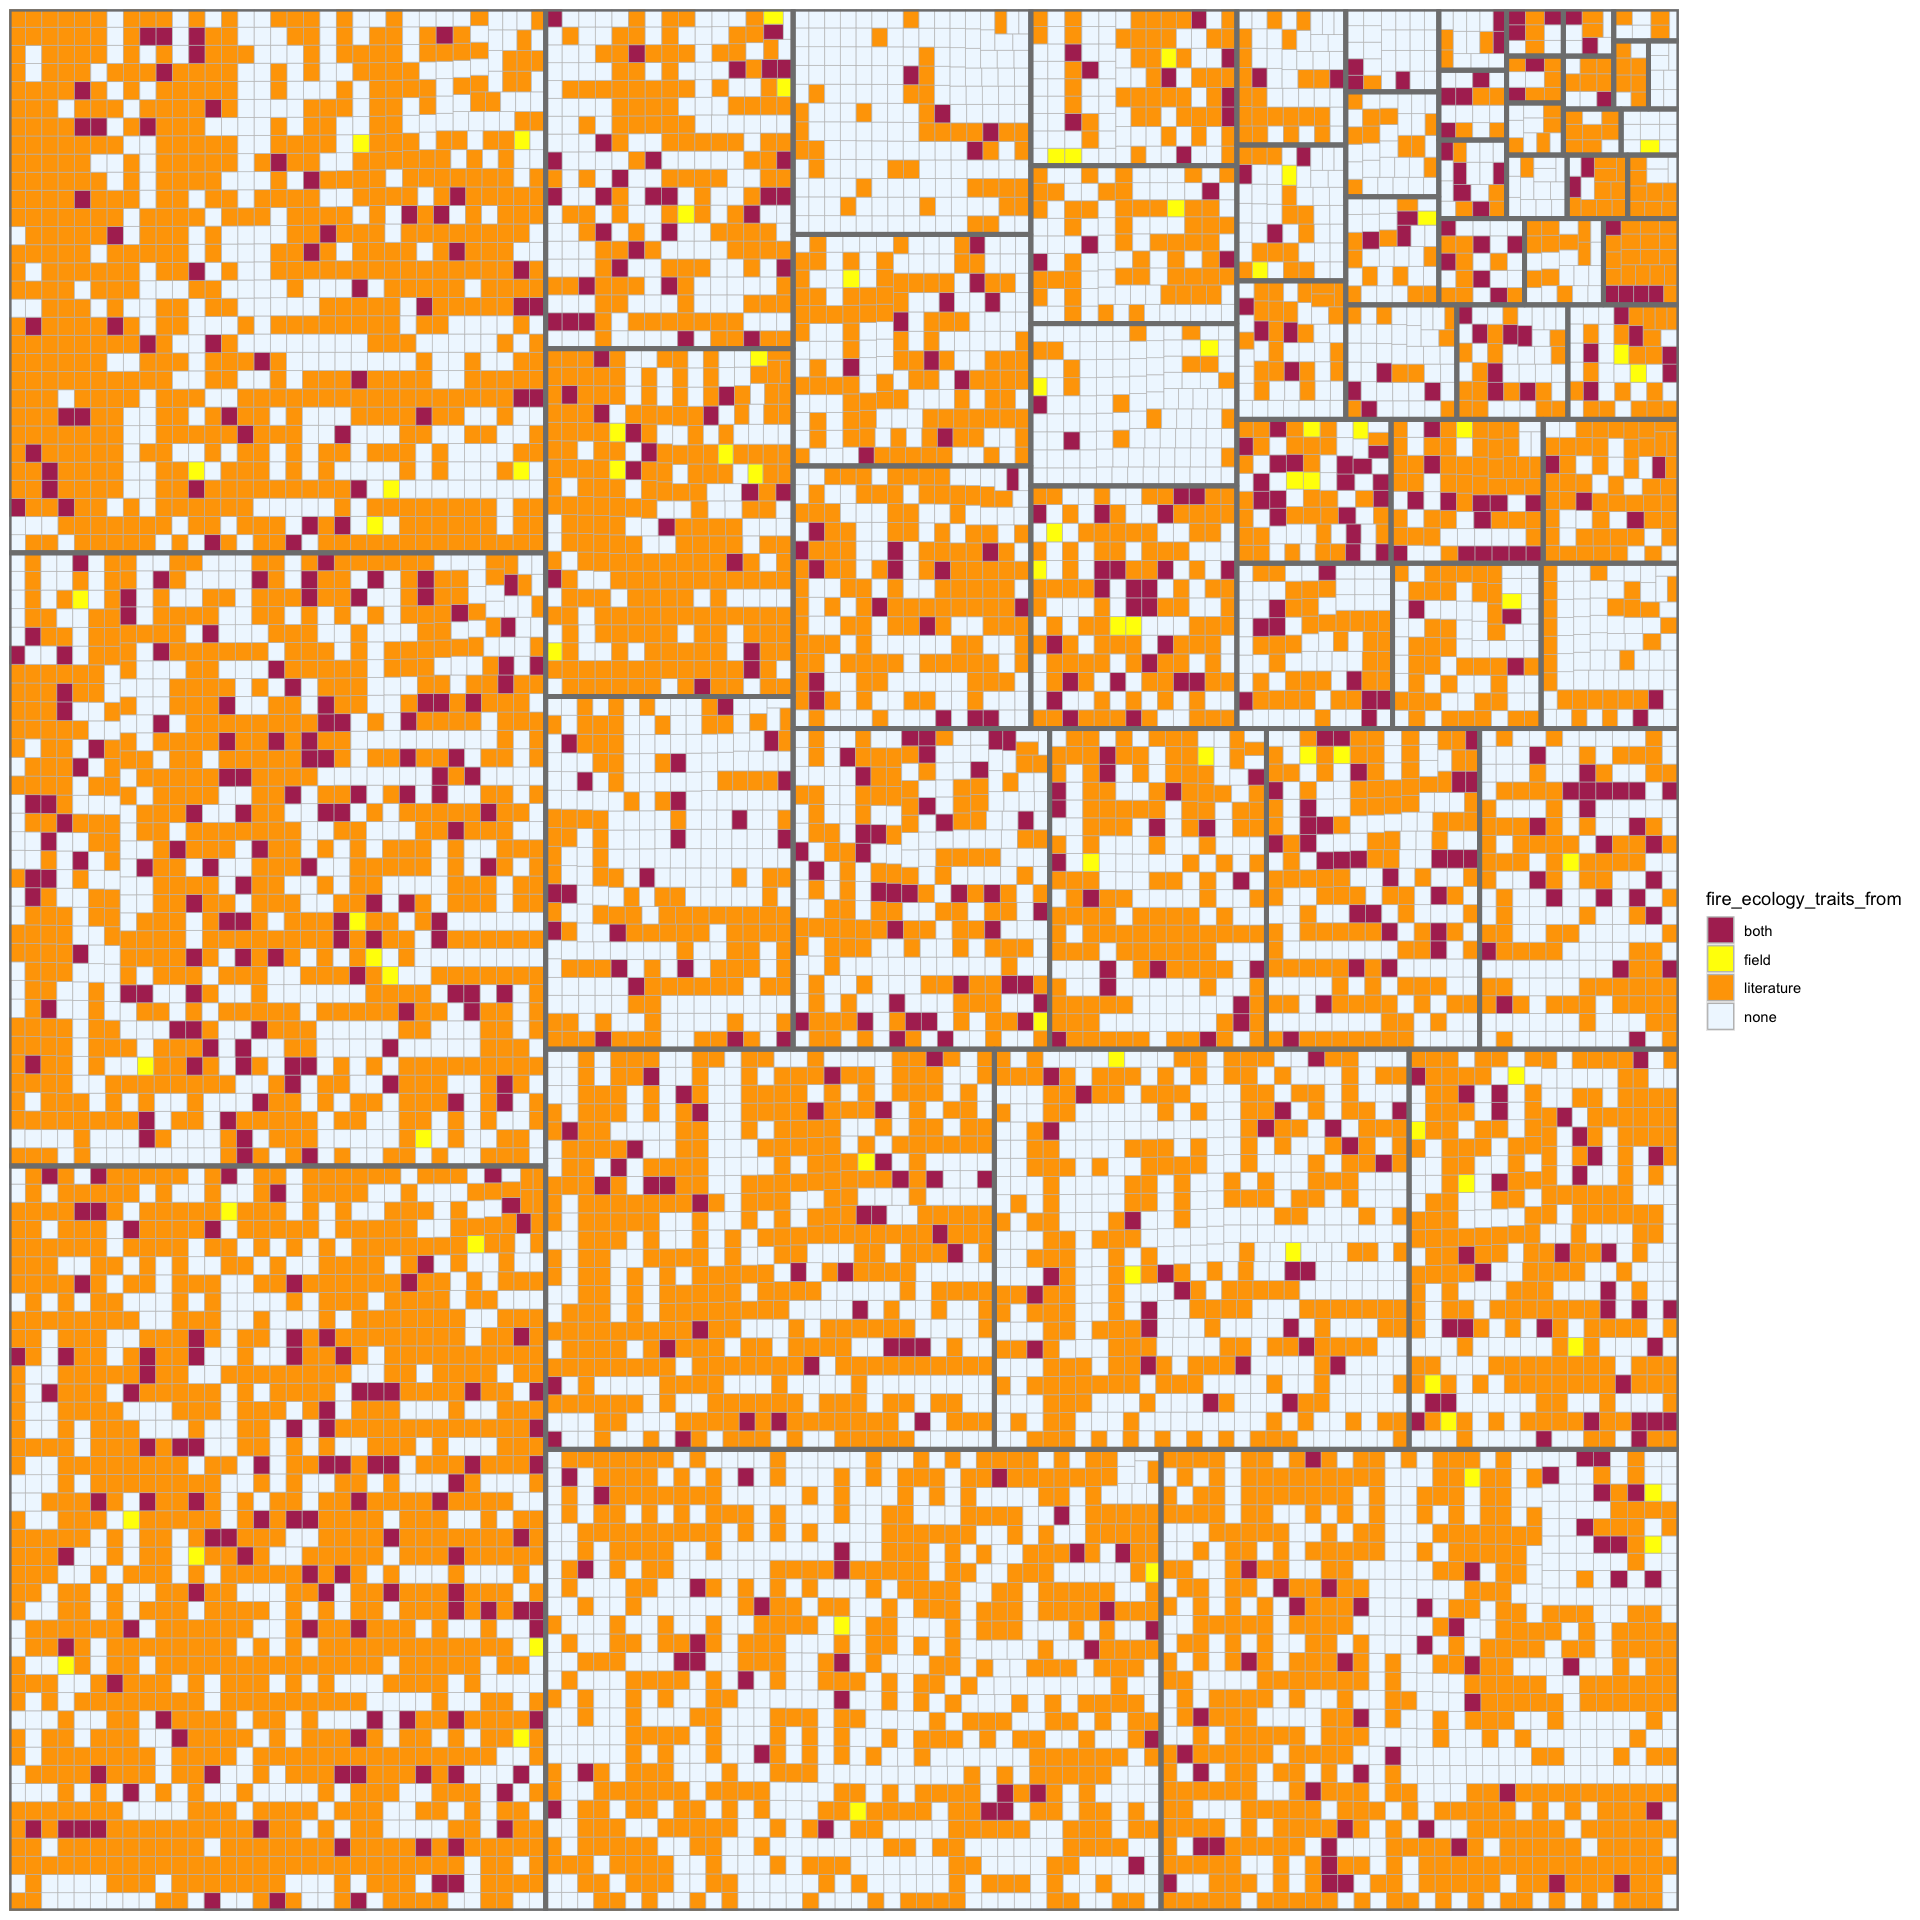

In [29]:
options(repr.plot.width=16,repr.plot.height=16) # Make plot larger


gt_table |>
    filter(!rank_order %in% exclude_mosses_liverworts) |>
ggplot(aes(area=1, fill = fire_ecology_traits_from, label = genus,
                subgroup = rank_order)) +
  geom_treemap() +
  geom_treemap_subgroup_border() +
  scale_fill_manual(values=clrs)

For the publication version of this plot, we do some additional tinkering of the groups so that we can include labels for the largest orders (but drop labels for very small groups):

In [30]:
gt_table_summary <- gt_table |> 
    filter(!rank_order %in% exclude_mosses_liverworts) |>
    group_by(rank_order) |> 
    summarise(genera = n_distinct(current_species), .groups = "drop") |>
    arrange(desc(genera))
print(gt_table_summary,n=25)

gt_table_ss <- gt_table |>
    filter(!rank_order %in% exclude_mosses_liverworts) |>
    mutate(rank_order = case_when(
        rank_order %in% c("unknown","unplaced") ~ "unplaced",
        TRUE ~ rank_order
        ))
#|>
#    mutate(rank_order = case_when(
#          rank_order %in% c("Asparagales","Asterales","Poales","Fabales","Myrtales","Proteales","Gentianales","Ericales","Lamiales","Sapindales","small orders") ~ rank_order ,
#          rank_order %in% c("unknown","unplaced") ~ "unplaced",
#          nchar(rank_order) < 10 ~ str_replace(rank_order, "ales$", "."),
#          nchar(rank_order) < 20 ~ str_replace(rank_order, "phyllales$", "ph."),
#          rank_order %in% c("Escalloniales") ~ "Esc.",
#          rank_order %in% c("Cucurbitales") ~ "Cuc.",
#          TRUE ~ abbreviate(rank_order)
#        )
#    )

# A tibble: 56 × 2
   rank_order     genera
   <chr>           <int>
 1 Poales           1351
 2 Asterales        1112
 3 Fabales           986
 4 Asparagales       960
 5 Myrtales          808
 6 Caryophyllales    607
 7 Lamiales          561
 8 Sapindales        365
 9 Rosales           295
10 Proteales         291
11 Malpighiales      284
12 Gentianales       278
13 Ericales          235
14 Apiales           231
15 Solanales         216
16 Malvales          211
17 Brassicales       186
18 unknown           181
19 Polypodiales      169
20 small orders      113
21 Alismatales       110
22 Ranunculales      109
23 Saxifragales       87
24 unplaced           83
25 Pinales            77
# ℹ 31 more rows


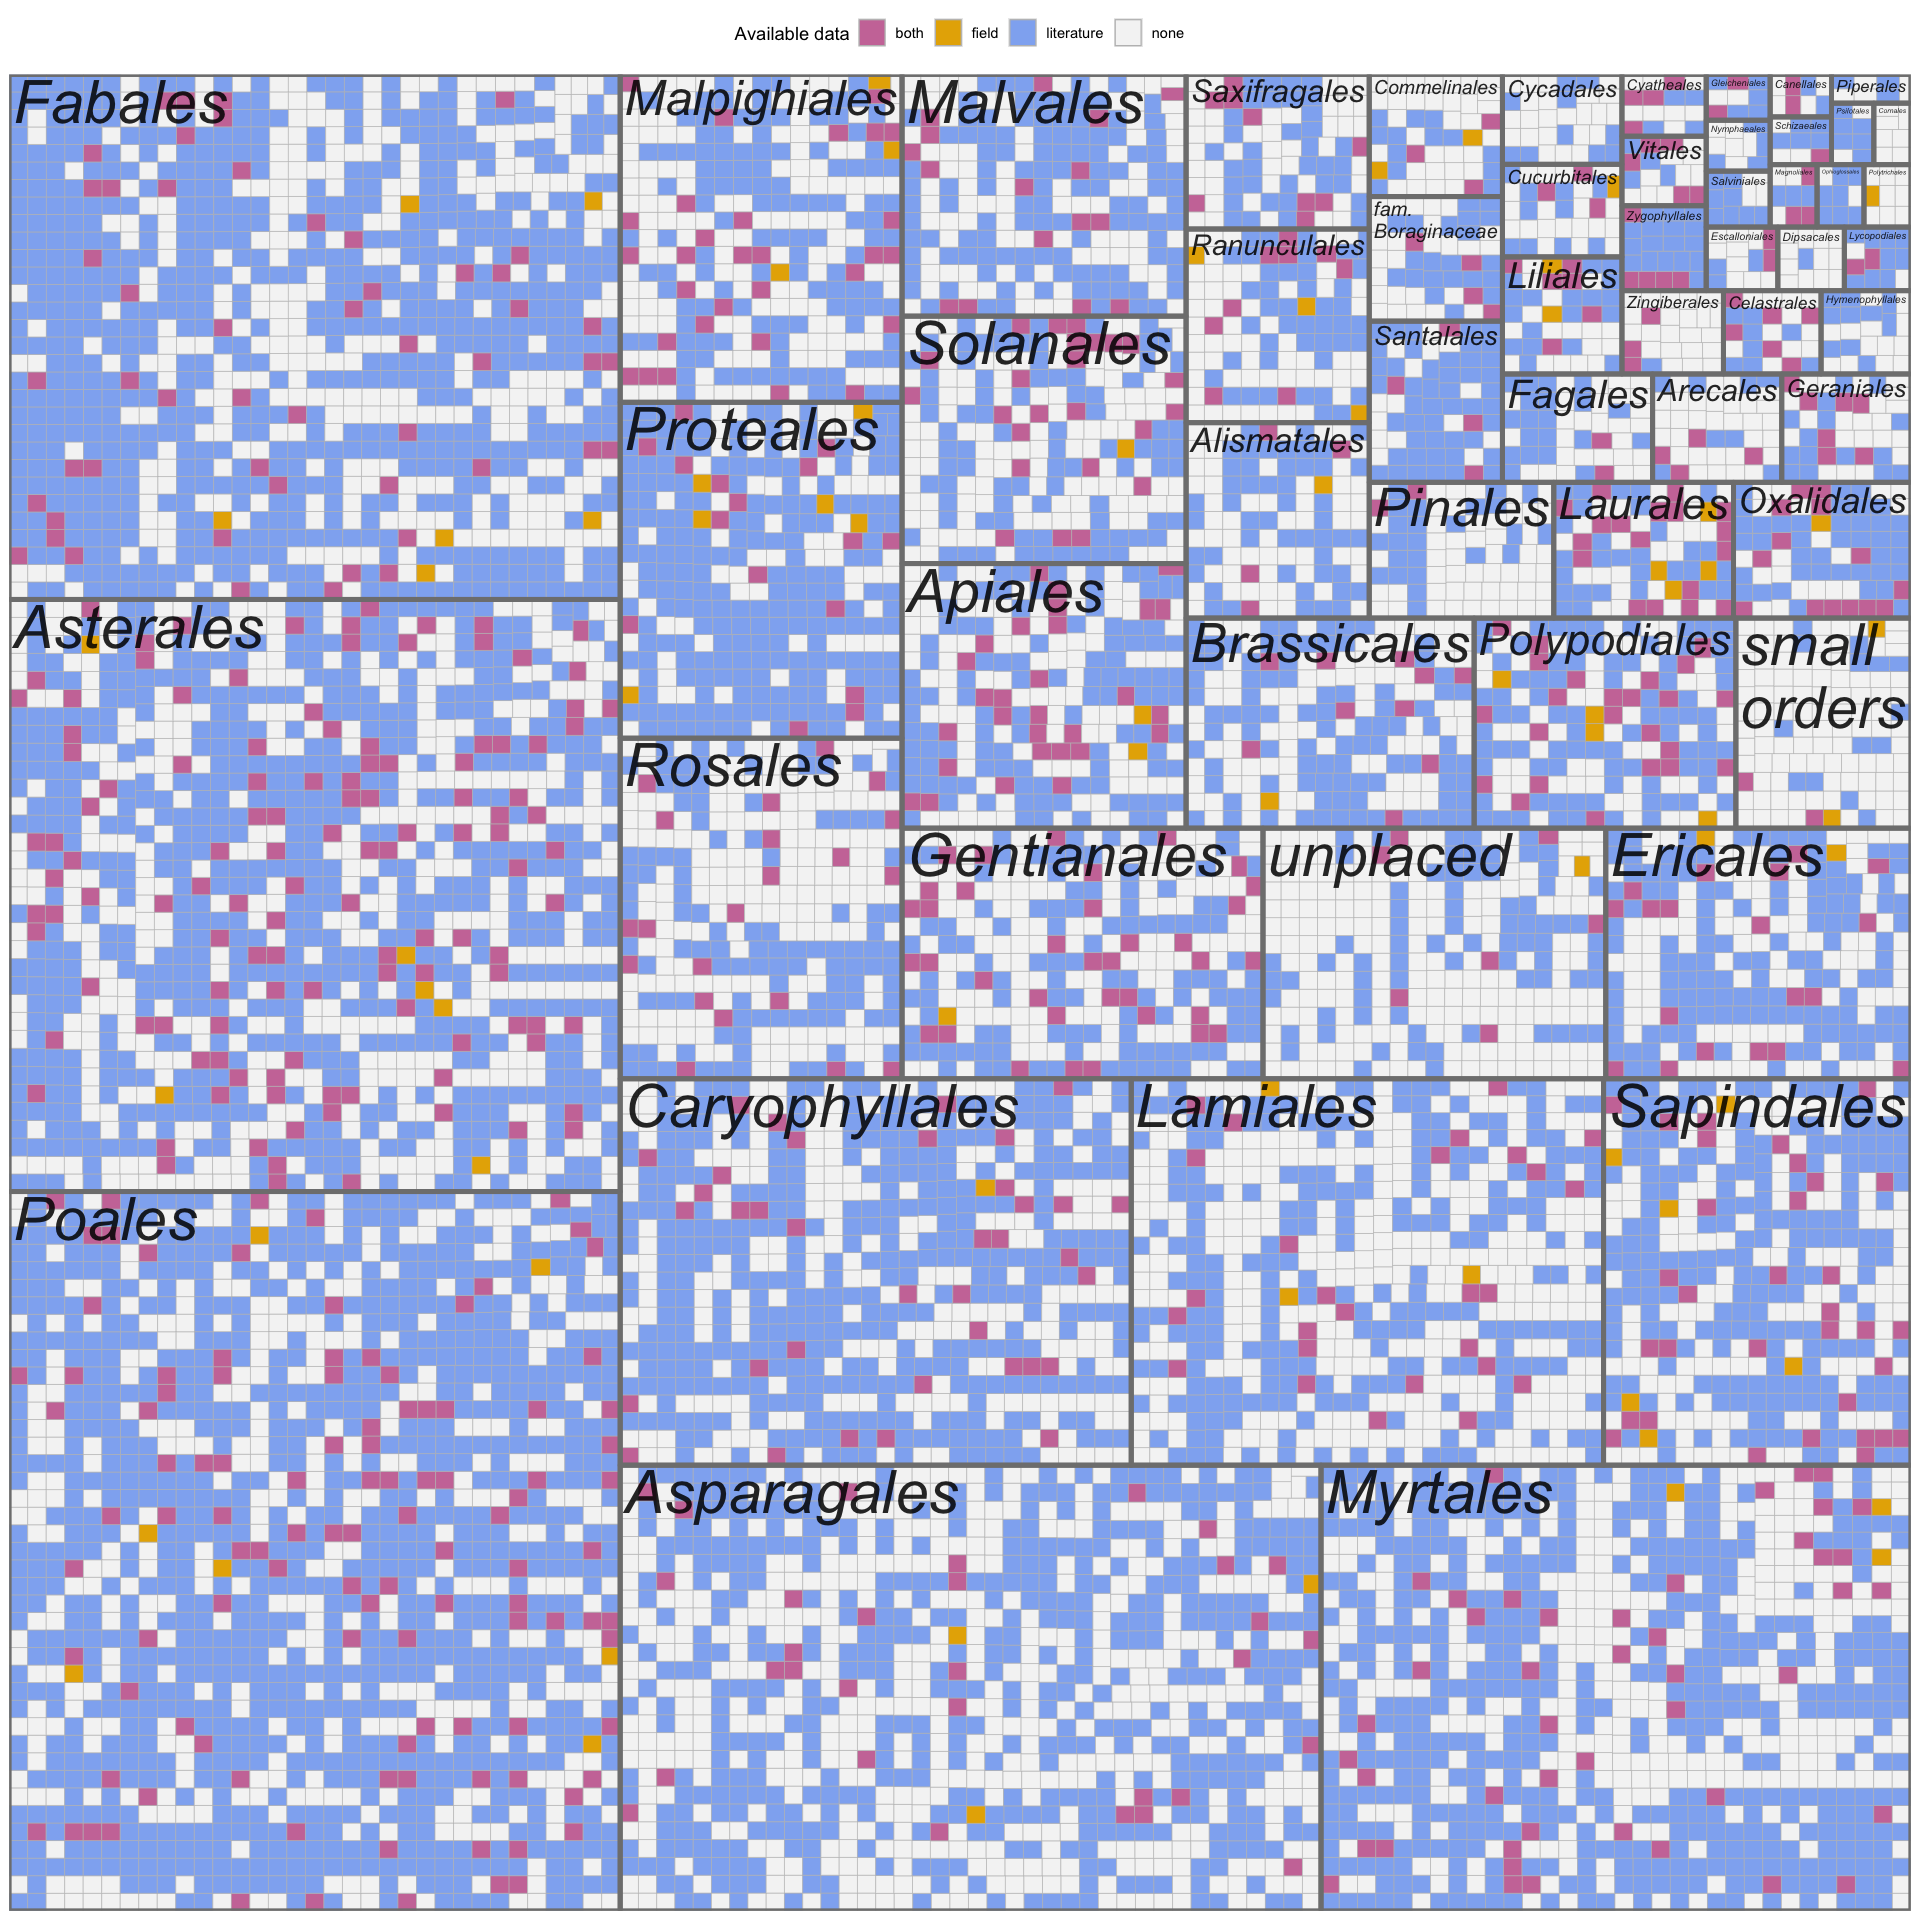

In [31]:
clrs <- c(none="whitesmoke", literature="#90B2F2", field="#E6AF00", both="#CC79A7")
    
ggplot(gt_table_ss, aes(area=1, fill = fire_ecology_traits_from, label = genus,
                subgroup = rank_order)) +
  geom_treemap() +
  geom_treemap_subgroup_text(
    place = "topleft", 
    grow = F, 
    reflow = T,
    alpha = 0.85, 
    colour = "black", 
    fontface = "italic", 
    min.size = 0) +
  geom_treemap_subgroup_border() +
  scale_fill_manual(values=clrs) +
  labs(fill='Available data') +
  theme(legend.position = "top")

## That is it for now!

✅ Job done! 😎👌🔥

You can:
- go [back home](../Instructions-and-workflow.ipynb),
- continue navigating the repo on [GitHub](https://github.com/ces-unsw-edu-au/fireveg-analysis)
- continue exploring the repo on [OSF](https://osf.io/h96q2/).
- visit the database at <http://fireecologyplants.net>

### R session information

In [32]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 15.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

time zone: Australia/Sydney
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] IRdisplay_1.1    treemapify_2.5.6 stringr_1.5.1    ggraph_2.2.1    
[5] igraph_2.0.3     tidyr_1.3.0      dplyr_1.1.4      ggplot2_3.5.0   

loaded via a namespace (and not attached):
 [1] viridis_0.6.4      utf8_1.2.4         generics_0.1.3     stringi_1.8.4     
 [5] digest_0.6.37      magrittr_2.0.3     evaluate_1.0.3     grid_4.3.1        
 [9] pbdZMQ_0.3-10      fastmap_1.2.0      rprojroot_2.0.4    jsonlit